In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.append(os.path.abspath(".."))

In [2]:
import torch
import scanpy as sc

In [3]:
DATASET_NAME = "LUNG-CITE"
BASE_DATA_DIR = os.path.join("..", "datasets", "data", "processed")  
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import random
import numpy as np
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [4]:
from utils.data_utils import dataset_config, load_dataset

hetero_data, data_dict = load_dataset(DATASET_NAME, BASE_DATA_DIR, DEVICE)

c:\Users\sonia\anaconda3\envs\MultiOmicsIntegration\Lib\site-packages\scanpy\preprocessing\_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))
c:\Users\sonia\anaconda3\envs\MultiOmicsIntegration\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:251: UserWarning: If you pass `n_top_genes`, all cutoffs are ignored.
  warnings.warn(msg, UserWarning)
c:\Users\sonia\anaconda3\envs\MultiOmicsIntegration\Lib\site-packages\scanpy\preprocessing\_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [5]:
from utils.graph_utils import (
    calculate_modality_jaccard,
    plot_degree_distributions,
    plot_modality_umaps
)
import matplotlib.pyplot as plt

def visualize_individual_metrics(hetero_data, data_dict, config):
    """Visualize per-modality graph metrics using utils"""
    modalities = config["modalities"]
    
    # Calculate and print Jaccard scores
    jaccard_results = {
        m: calculate_modality_jaccard(hetero_data['cell', m, 'cell'].edge_index)
        for m in modalities
    }
    print("Neighborhood Consistency Scores:")
    for mod, score in jaccard_results.items():
        print(f"- {mod}: {score:.3f}")
    
    # Plot distributions
    plot_degree_distributions(hetero_data, modalities)
    plot_modality_umaps(data_dict, modalities)
    
    plt.show()

# visualize_individual_metrics(hetero_data, data_dict, dataset_config[DATASET_NAME]) - run if you want to see metrics for individual modalities

In [6]:
import torch
print(torch.__version__)          # e.g., 2.0.1
print(torch.version.cuda)         # e.g., 11.7 (or "None" for CPU-only)

2.5.1
12.4


In [7]:
import torch
print(torch.__version__)          # PyTorch version
print(torch.cuda.is_available())  # Should return True if CUDA is available
print(torch.version.cuda)         # CUDA version (e.g., 11.7)

2.5.1
True
12.4


In [8]:
import scanpy as sc

modalities = dataset_config[DATASET_NAME]["modalities"]
print(modalities)

data = {}

for modality in modalities:
    data[modality] = sc.read_h5ad(f"./../datasets/data/processed/{DATASET_NAME}_{modality}.h5ad")

cell_metadata = data[modalities[0]].obs.copy()

data

['ADT', 'RNA']


{'ADT': AnnData object with n_obs × n_vars = 10470 × 52
     obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'tissue', 'group', 'volume', 'sampleID', 'celltype', 'nCount_ADT', 'nFeature_ADT'
     var: 'count', 'percentile', 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
     obsm: 'X_apca'
     varm: 'APCA',
 'RNA': AnnData object with n_obs × n_vars = 10470 × 3000
     obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'tissue', 'group', 'volume', 'sampleID', 'celltype', 'nCount_ADT', 'nFeature_ADT'
     var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
     obsm: 'X_pca'
     varm: 'PCs'}

In [9]:
import torch

processed = {m: {'x': torch.tensor(data[m].X, dtype=torch.float)} for m in modalities}
processed

# processed = {m: {'x': torch.tensor(data[m].obsm['X_glue'], dtype=torch.float)} for m in modalities}
# processed - for the match data with precomputed latent representations

{'ADT': {'x': tensor([[-0.1067,  0.2336, -0.3761,  ...,  0.0417,  0.7129,  1.7810],
          [-0.0816,  0.6819,  0.1002,  ...,  2.8420,  0.1367, -0.2340],
          [ 0.1335, -0.1355, -0.0772,  ..., -0.8012, -0.0301, -0.7497],
          ...,
          [-0.2312,  0.4648,  0.3953,  ...,  0.1589, -0.9881,  0.5103],
          [-0.3114, -1.4292, -0.3896,  ...,  0.0273,  0.2220,  1.4590],
          [-0.4793,  0.5241, -1.0956,  ...,  0.8601, -0.9881,  0.5941]])},
 'RNA': {'x': tensor([[-0.0301, -0.0906, -0.2151,  ..., -0.0625, -0.3316, -0.0567],
          [-0.0301, -0.0906, -0.2151,  ..., -0.0625, -0.3316, -0.0567],
          [-0.0301, -0.0906, -0.2151,  ..., -0.0625, -0.3316, -0.0567],
          ...,
          [-0.0301, -0.0906, -0.2151,  ..., -0.0625, -0.3316, -0.0567],
          [-0.0301, -0.0906, -0.2151,  ..., -0.0625,  6.1826, -0.0567],
          [-0.0301, -0.0906, -0.2151,  ..., -0.0625, -0.3316, -0.0567]])}}

In [10]:
from torch_geometric.data import HeteroData

# (1) Assign attributes after initialization,
hetero_data = HeteroData(processed)
hetero_data['cell'].x = torch.cat([hetero_data[m].x for m in modalities], dim=1)
hetero_data['cell'].metadata = cell_metadata 
hetero_data

HeteroData(
  ADT={ x=[10470, 52] },
  RNA={ x=[10470, 3000] },
  cell={
    x=[10470, 3052],
    metadata=                  orig.ident  nCount_RNA  nFeature_RNA  tissue  group  volume  \
GACGTGCTCAGAGACG           0       753.0           430       0      2       1   
GATTCAGTCACTGGGC           0      4848.0          1570       1      4       0   
CTCGAGGGTATTACCG           0       769.0           488       0      3       1   
TAGACCACATGGGAAC           0      1190.0           577       1      5       0   
TGTGGTAGTCACAAGG           0      1786.0           826       0      0       0   
...                      ...         ...           ...     ...    ...     ...   
AACTGGTCAATAGCGG           0      3010.0          1276       1      4       0   
TGTCCCAGTTGAGTTC           0      1791.0          1033       1      4       0   
CTCCTAGTCACCTCGT           0      1814.0           792       0      2       1   
CACCAGGGTACGCTGC           0       105.0            89       0      0       0   
GT

In [11]:
from torch_geometric.nn import knn_graph

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hetero_data = hetero_data.to(device)

for m in modalities:
    hetero_data['cell', m, 'cell'].edge_index = knn_graph(
        hetero_data[m].x,
        k=10,
        cosine=True,
        num_workers=16
    )

In [12]:
hetero_data = hetero_data.cpu() 
output_path = os.path.join(os.path.join(BASE_DATA_DIR, DATASET_NAME), f"{DATASET_NAME}_processed.pt")
torch.save(hetero_data, output_path)
print(f"Saved processed data to {output_path}")

Saved processed data to ..\datasets\data\processed\LUNG-CITE\LUNG-CITE_processed.pt


In [11]:
output_path = os.path.join(os.path.join(BASE_DATA_DIR, DATASET_NAME), f"{DATASET_NAME}_processed.pt")
loaded_data = torch.load(output_path)
hetero_data = loaded_data.to(DEVICE)  # Move back to GPU if needed

C:\Users\wzy66\AppData\Local\Temp\ipykernel_40168\643221056.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_data = torch.load(output_path)


In [13]:
import torch
from torch_geometric.loader import NeighborLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hetero_data = hetero_data.to(device)

num_cells = hetero_data['cell'].x.size(0)
cell_idx = torch.arange(num_cells, device=device)

neighbor_loader = NeighborLoader(
    hetero_data,
    num_neighbors={
        ('cell', m, 'cell'): [5, 5] for m in modalities
    },
    input_nodes=('cell', cell_idx),
    batch_size=256  # choose an appropriate batch size for your memory constraints
)

for batch in neighbor_loader:
    print(batch)

HeteroData(
  ADT={
    x=[0, 52],
    n_id=[0],
  },
  RNA={
    x=[0, 3000],
    n_id=[0],
  },
  cell={
    x=[8200, 3052],
    metadata=                  orig.ident  nCount_RNA  nFeature_RNA  tissue  group  volume  \
GACGTGCTCAGAGACG           0       753.0           430       0      2       1   
GATTCAGTCACTGGGC           0      4848.0          1570       1      4       0   
CTCGAGGGTATTACCG           0       769.0           488       0      3       1   
TAGACCACATGGGAAC           0      1190.0           577       1      5       0   
TGTGGTAGTCACAAGG           0      1786.0           826       0      0       0   
...                      ...         ...           ...     ...    ...     ...   
AACTGGTCAATAGCGG           0      3010.0          1276       1      4       0   
TGTCCCAGTTGAGTTC           0      1791.0          1033       1      4       0   
CTCCTAGTCACCTCGT           0      1814.0           792       0      2       1   
CACCAGGGTACGCTGC           0       105.0          

In [14]:
from model.model import HeteroGraphAE, GraphAELightningModule
# Hyperparameters.
in_channels = hetero_data['cell'].x.size(1)
hidden_channels = 512
latent_channels = 512   # Dimensionality of the latent space.
num_layers = 2
learning_rate = 1e-4
n_epochs = 500 # change to 500 for full training

# Instantiate the Lightning module.
model = GraphAELightningModule(
    in_channels=in_channels,
    hidden_channels=hidden_channels,
    latent_channels=latent_channels,
    modalities=modalities,
    num_layers=num_layers,
    learning_rate=learning_rate,
    total_epochs=n_epochs,
    warmup_epochs=3,
    num_clusters=20,
    clustering_weight=.01
)

In [15]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    monitor='train_loss',         # monitor your training loss
    dirpath='checkpoints',        # directory to save checkpoints
    filename='graph_ae-{epoch:02d}-{train_loss:.2f}',
    save_top_k=1,                 # save the best model
    mode='min'
)

early_stop_callback = EarlyStopping(
    monitor='train_loss',
    min_delta=0.001,
    patience=3,
    verbose=True,
    mode='min'
)

trainer = Trainer(
    max_epochs=n_epochs,
    accelerator="gpu",
    devices=1,
    callbacks=[early_stop_callback, checkpoint_callback]
)
trainer.fit(model, train_dataloaders=neighbor_loader)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
c:\Users\sonia\anaconda3\envs\MultiOmicsIntegration\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
c:\Users\sonia\anaconda3\envs\MultiOmicsIntegration\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\sonia\Documents\University\Cambridge\L65\Multi O

Epoch 0: 100%|██████████| 41/41 [00:30<00:00,  1.36it/s, v_num=2, train_loss=1.780, cluster_loss=28.60, ADT_recon_loss=0.706, RNA_recon_loss=0.791]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved. New best score: 1.782


Epoch 1: 100%|██████████| 41/41 [00:29<00:00,  1.40it/s, v_num=2, train_loss=1.510, cluster_loss=28.50, ADT_recon_loss=0.597, RNA_recon_loss=0.624]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.277 >= min_delta = 0.001. New best score: 1.506


Epoch 2: 100%|██████████| 41/41 [00:29<00:00,  1.38it/s, v_num=2, train_loss=1.130, cluster_loss=29.00, ADT_recon_loss=0.421, RNA_recon_loss=0.416]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.379 >= min_delta = 0.001. New best score: 1.126


Epoch 3: 100%|██████████| 41/41 [00:32<00:00,  1.28it/s, v_num=2, train_loss=0.950, cluster_loss=28.60, ADT_recon_loss=0.329, RNA_recon_loss=0.336]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.176 >= min_delta = 0.001. New best score: 0.950


Epoch 4: 100%|██████████| 41/41 [00:29<00:00,  1.39it/s, v_num=2, train_loss=0.858, cluster_loss=27.20, ADT_recon_loss=0.285, RNA_recon_loss=0.301]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.092 >= min_delta = 0.001. New best score: 0.858


Epoch 5: 100%|██████████| 41/41 [00:29<00:00,  1.37it/s, v_num=2, train_loss=0.797, cluster_loss=25.80, ADT_recon_loss=0.257, RNA_recon_loss=0.282]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.061 >= min_delta = 0.001. New best score: 0.797


Epoch 6: 100%|██████████| 41/41 [00:29<00:00,  1.38it/s, v_num=2, train_loss=0.749, cluster_loss=24.60, ADT_recon_loss=0.235, RNA_recon_loss=0.268]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.048 >= min_delta = 0.001. New best score: 0.749


Epoch 7: 100%|██████████| 41/41 [00:30<00:00,  1.37it/s, v_num=2, train_loss=0.707, cluster_loss=23.80, ADT_recon_loss=0.214, RNA_recon_loss=0.255]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.042 >= min_delta = 0.001. New best score: 0.707


Epoch 8: 100%|██████████| 41/41 [00:29<00:00,  1.37it/s, v_num=2, train_loss=0.671, cluster_loss=23.10, ADT_recon_loss=0.196, RNA_recon_loss=0.244]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.036 >= min_delta = 0.001. New best score: 0.671


Epoch 9: 100%|██████████| 41/41 [00:30<00:00,  1.36it/s, v_num=2, train_loss=0.641, cluster_loss=22.60, ADT_recon_loss=0.181, RNA_recon_loss=0.233]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.030 >= min_delta = 0.001. New best score: 0.641


Epoch 10: 100%|██████████| 41/41 [00:30<00:00,  1.35it/s, v_num=2, train_loss=0.614, cluster_loss=22.30, ADT_recon_loss=0.168, RNA_recon_loss=0.223]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.027 >= min_delta = 0.001. New best score: 0.614


Epoch 11: 100%|██████████| 41/41 [00:30<00:00,  1.33it/s, v_num=2, train_loss=0.590, cluster_loss=22.00, ADT_recon_loss=0.157, RNA_recon_loss=0.213]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.023 >= min_delta = 0.001. New best score: 0.590


Epoch 12: 100%|██████████| 41/41 [00:30<00:00,  1.35it/s, v_num=2, train_loss=0.568, cluster_loss=21.80, ADT_recon_loss=0.149, RNA_recon_loss=0.202]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.022 >= min_delta = 0.001. New best score: 0.568


Epoch 13: 100%|██████████| 41/41 [00:30<00:00,  1.35it/s, v_num=2, train_loss=0.551, cluster_loss=21.70, ADT_recon_loss=0.141, RNA_recon_loss=0.193]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.017 >= min_delta = 0.001. New best score: 0.551


Epoch 14: 100%|██████████| 41/41 [00:29<00:00,  1.38it/s, v_num=2, train_loss=0.532, cluster_loss=21.60, ADT_recon_loss=0.132, RNA_recon_loss=0.184]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.019 >= min_delta = 0.001. New best score: 0.532


Epoch 15: 100%|██████████| 41/41 [00:29<00:00,  1.38it/s, v_num=2, train_loss=0.517, cluster_loss=21.50, ADT_recon_loss=0.126, RNA_recon_loss=0.176]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.015 >= min_delta = 0.001. New best score: 0.517


Epoch 16: 100%|██████████| 41/41 [00:29<00:00,  1.38it/s, v_num=2, train_loss=0.501, cluster_loss=21.40, ADT_recon_loss=0.121, RNA_recon_loss=0.167]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.015 >= min_delta = 0.001. New best score: 0.501


Epoch 17: 100%|██████████| 41/41 [00:29<00:00,  1.37it/s, v_num=2, train_loss=0.491, cluster_loss=21.40, ADT_recon_loss=0.116, RNA_recon_loss=0.161]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.491


Epoch 18: 100%|██████████| 41/41 [00:30<00:00,  1.34it/s, v_num=2, train_loss=0.476, cluster_loss=21.30, ADT_recon_loss=0.110, RNA_recon_loss=0.153]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.015 >= min_delta = 0.001. New best score: 0.476


Epoch 19: 100%|██████████| 41/41 [00:29<00:00,  1.41it/s, v_num=2, train_loss=0.465, cluster_loss=21.20, ADT_recon_loss=0.106, RNA_recon_loss=0.147]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.465


Epoch 20: 100%|██████████| 41/41 [00:30<00:00,  1.37it/s, v_num=2, train_loss=0.453, cluster_loss=21.20, ADT_recon_loss=0.102, RNA_recon_loss=0.140]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.453


Epoch 21: 100%|██████████| 41/41 [00:30<00:00,  1.36it/s, v_num=2, train_loss=0.443, cluster_loss=21.10, ADT_recon_loss=0.0981, RNA_recon_loss=0.134]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.443


Epoch 22: 100%|██████████| 41/41 [00:30<00:00,  1.36it/s, v_num=2, train_loss=0.435, cluster_loss=21.00, ADT_recon_loss=0.0948, RNA_recon_loss=0.131]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.435


Epoch 23: 100%|██████████| 41/41 [00:29<00:00,  1.39it/s, v_num=2, train_loss=0.427, cluster_loss=20.90, ADT_recon_loss=0.0917, RNA_recon_loss=0.126]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.427


Epoch 24: 100%|██████████| 41/41 [00:30<00:00,  1.35it/s, v_num=2, train_loss=0.418, cluster_loss=20.80, ADT_recon_loss=0.0889, RNA_recon_loss=0.121]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.418


Epoch 25: 100%|██████████| 41/41 [00:31<00:00,  1.28it/s, v_num=2, train_loss=0.409, cluster_loss=20.70, ADT_recon_loss=0.0853, RNA_recon_loss=0.118]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.409


Epoch 26: 100%|██████████| 41/41 [00:30<00:00,  1.33it/s, v_num=2, train_loss=0.402, cluster_loss=20.50, ADT_recon_loss=0.0833, RNA_recon_loss=0.113]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.402


Epoch 27: 100%|██████████| 41/41 [00:31<00:00,  1.32it/s, v_num=2, train_loss=0.396, cluster_loss=20.40, ADT_recon_loss=0.0815, RNA_recon_loss=0.110]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.396


Epoch 28: 100%|██████████| 41/41 [00:32<00:00,  1.25it/s, v_num=2, train_loss=0.389, cluster_loss=20.30, ADT_recon_loss=0.0786, RNA_recon_loss=0.107]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.389


Epoch 29: 100%|██████████| 41/41 [00:32<00:00,  1.26it/s, v_num=2, train_loss=0.382, cluster_loss=20.20, ADT_recon_loss=0.0772, RNA_recon_loss=0.104]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.382


Epoch 30: 100%|██████████| 41/41 [00:30<00:00,  1.33it/s, v_num=2, train_loss=0.377, cluster_loss=20.00, ADT_recon_loss=0.0751, RNA_recon_loss=0.101]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.377


Epoch 31: 100%|██████████| 41/41 [00:30<00:00,  1.36it/s, v_num=2, train_loss=0.370, cluster_loss=19.90, ADT_recon_loss=0.0727, RNA_recon_loss=0.0983]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.370


Epoch 32: 100%|██████████| 41/41 [00:30<00:00,  1.33it/s, v_num=2, train_loss=0.364, cluster_loss=19.80, ADT_recon_loss=0.0707, RNA_recon_loss=0.0952]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.364


Epoch 33: 100%|██████████| 41/41 [00:30<00:00,  1.33it/s, v_num=2, train_loss=0.360, cluster_loss=19.70, ADT_recon_loss=0.0702, RNA_recon_loss=0.0928]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.360


Epoch 34: 100%|██████████| 41/41 [00:30<00:00,  1.35it/s, v_num=2, train_loss=0.355, cluster_loss=19.60, ADT_recon_loss=0.0682, RNA_recon_loss=0.0915]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.355


Epoch 35: 100%|██████████| 41/41 [00:30<00:00,  1.33it/s, v_num=2, train_loss=0.350, cluster_loss=19.40, ADT_recon_loss=0.0665, RNA_recon_loss=0.0889]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.350


Epoch 36: 100%|██████████| 41/41 [00:30<00:00,  1.36it/s, v_num=2, train_loss=0.345, cluster_loss=19.30, ADT_recon_loss=0.0648, RNA_recon_loss=0.0873]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.345


Epoch 37: 100%|██████████| 41/41 [00:31<00:00,  1.31it/s, v_num=2, train_loss=0.341, cluster_loss=19.20, ADT_recon_loss=0.064, RNA_recon_loss=0.0849] 

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.341


Epoch 38: 100%|██████████| 41/41 [00:30<00:00,  1.33it/s, v_num=2, train_loss=0.337, cluster_loss=19.10, ADT_recon_loss=0.0628, RNA_recon_loss=0.0835]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.337


Epoch 39: 100%|██████████| 41/41 [00:30<00:00,  1.34it/s, v_num=2, train_loss=0.331, cluster_loss=18.90, ADT_recon_loss=0.061, RNA_recon_loss=0.0809] 

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.331


Epoch 40: 100%|██████████| 41/41 [00:30<00:00,  1.34it/s, v_num=2, train_loss=0.328, cluster_loss=18.80, ADT_recon_loss=0.0597, RNA_recon_loss=0.0797]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.328


Epoch 41: 100%|██████████| 41/41 [00:31<00:00,  1.30it/s, v_num=2, train_loss=0.325, cluster_loss=18.70, ADT_recon_loss=0.0591, RNA_recon_loss=0.079] 

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.325


Epoch 42: 100%|██████████| 41/41 [00:30<00:00,  1.34it/s, v_num=2, train_loss=0.321, cluster_loss=18.60, ADT_recon_loss=0.058, RNA_recon_loss=0.0769]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.321


Epoch 43: 100%|██████████| 41/41 [00:31<00:00,  1.31it/s, v_num=2, train_loss=0.317, cluster_loss=18.50, ADT_recon_loss=0.0567, RNA_recon_loss=0.0753]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.317


Epoch 44: 100%|██████████| 41/41 [00:29<00:00,  1.37it/s, v_num=2, train_loss=0.314, cluster_loss=18.40, ADT_recon_loss=0.0561, RNA_recon_loss=0.0739]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.314


Epoch 45: 100%|██████████| 41/41 [00:30<00:00,  1.35it/s, v_num=2, train_loss=0.309, cluster_loss=18.20, ADT_recon_loss=0.0546, RNA_recon_loss=0.0724]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.309


Epoch 46: 100%|██████████| 41/41 [00:29<00:00,  1.37it/s, v_num=2, train_loss=0.306, cluster_loss=18.10, ADT_recon_loss=0.0541, RNA_recon_loss=0.0709]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.306


Epoch 47: 100%|██████████| 41/41 [00:30<00:00,  1.35it/s, v_num=2, train_loss=0.304, cluster_loss=18.00, ADT_recon_loss=0.0534, RNA_recon_loss=0.0702]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.304


Epoch 48: 100%|██████████| 41/41 [00:31<00:00,  1.30it/s, v_num=2, train_loss=0.302, cluster_loss=17.90, ADT_recon_loss=0.0532, RNA_recon_loss=0.0695]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.302


Epoch 49: 100%|██████████| 41/41 [00:31<00:00,  1.32it/s, v_num=2, train_loss=0.298, cluster_loss=17.80, ADT_recon_loss=0.0523, RNA_recon_loss=0.0675]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.298


Epoch 50: 100%|██████████| 41/41 [00:30<00:00,  1.33it/s, v_num=2, train_loss=0.295, cluster_loss=17.70, ADT_recon_loss=0.051, RNA_recon_loss=0.0669] 

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.295


Epoch 51: 100%|██████████| 41/41 [00:30<00:00,  1.36it/s, v_num=2, train_loss=0.292, cluster_loss=17.60, ADT_recon_loss=0.0508, RNA_recon_loss=0.0659]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.292


Epoch 52: 100%|██████████| 41/41 [00:30<00:00,  1.36it/s, v_num=2, train_loss=0.289, cluster_loss=17.50, ADT_recon_loss=0.0494, RNA_recon_loss=0.0647]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.289


Epoch 53: 100%|██████████| 41/41 [00:30<00:00,  1.36it/s, v_num=2, train_loss=0.286, cluster_loss=17.40, ADT_recon_loss=0.0491, RNA_recon_loss=0.0635]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.286


Epoch 54: 100%|██████████| 41/41 [00:31<00:00,  1.28it/s, v_num=2, train_loss=0.284, cluster_loss=17.30, ADT_recon_loss=0.0484, RNA_recon_loss=0.0629]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.284


Epoch 55: 100%|██████████| 41/41 [00:40<00:00,  1.01it/s, v_num=2, train_loss=0.281, cluster_loss=17.20, ADT_recon_loss=0.0478, RNA_recon_loss=0.0617]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.281


Epoch 56: 100%|██████████| 41/41 [00:46<00:00,  0.88it/s, v_num=2, train_loss=0.278, cluster_loss=17.10, ADT_recon_loss=0.047, RNA_recon_loss=0.0608] 

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.278


Epoch 57: 100%|██████████| 41/41 [00:35<00:00,  1.15it/s, v_num=2, train_loss=0.277, cluster_loss=17.00, ADT_recon_loss=0.0465, RNA_recon_loss=0.0608]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.277


Epoch 58: 100%|██████████| 41/41 [00:33<00:00,  1.22it/s, v_num=2, train_loss=0.274, cluster_loss=16.90, ADT_recon_loss=0.0456, RNA_recon_loss=0.0594]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.274


Epoch 59: 100%|██████████| 41/41 [00:39<00:00,  1.04it/s, v_num=2, train_loss=0.272, cluster_loss=16.80, ADT_recon_loss=0.0455, RNA_recon_loss=0.0591]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.272


Epoch 60: 100%|██████████| 41/41 [00:44<00:00,  0.93it/s, v_num=2, train_loss=0.271, cluster_loss=16.60, ADT_recon_loss=0.0458, RNA_recon_loss=0.0582]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.271


Epoch 61: 100%|██████████| 41/41 [00:51<00:00,  0.79it/s, v_num=2, train_loss=0.268, cluster_loss=16.60, ADT_recon_loss=0.0442, RNA_recon_loss=0.0578]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.268


Epoch 62: 100%|██████████| 41/41 [00:52<00:00,  0.78it/s, v_num=2, train_loss=0.266, cluster_loss=16.50, ADT_recon_loss=0.0442, RNA_recon_loss=0.0565]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.266


Epoch 63: 100%|██████████| 41/41 [01:12<00:00,  0.57it/s, v_num=2, train_loss=0.264, cluster_loss=16.40, ADT_recon_loss=0.044, RNA_recon_loss=0.0562] 

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.264


Epoch 64: 100%|██████████| 41/41 [01:29<00:00,  0.46it/s, v_num=2, train_loss=0.262, cluster_loss=16.30, ADT_recon_loss=0.0438, RNA_recon_loss=0.0553]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.262


Epoch 65: 100%|██████████| 41/41 [01:29<00:00,  0.46it/s, v_num=2, train_loss=0.258, cluster_loss=16.20, ADT_recon_loss=0.0423, RNA_recon_loss=0.054] 

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.258


Epoch 66: 100%|██████████| 41/41 [02:26<00:00,  0.28it/s, v_num=2, train_loss=0.257, cluster_loss=16.10, ADT_recon_loss=0.0417, RNA_recon_loss=0.0543]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.257


Epoch 67: 100%|██████████| 41/41 [02:45<00:00,  0.25it/s, v_num=2, train_loss=0.255, cluster_loss=16.00, ADT_recon_loss=0.042, RNA_recon_loss=0.0527] 

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.255


Epoch 68: 100%|██████████| 41/41 [02:45<00:00,  0.25it/s, v_num=2, train_loss=0.253, cluster_loss=15.90, ADT_recon_loss=0.041, RNA_recon_loss=0.0528]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.253


Epoch 69: 100%|██████████| 41/41 [02:45<00:00,  0.25it/s, v_num=2, train_loss=0.251, cluster_loss=15.90, ADT_recon_loss=0.0406, RNA_recon_loss=0.052]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.251


Epoch 71: 100%|██████████| 41/41 [00:39<00:00,  1.03it/s, v_num=2, train_loss=0.249, cluster_loss=15.70, ADT_recon_loss=0.0404, RNA_recon_loss=0.0515]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.249


Epoch 72: 100%|██████████| 41/41 [00:32<00:00,  1.27it/s, v_num=2, train_loss=0.246, cluster_loss=15.60, ADT_recon_loss=0.0395, RNA_recon_loss=0.0508]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.246


Epoch 73: 100%|██████████| 41/41 [00:30<00:00,  1.34it/s, v_num=2, train_loss=0.245, cluster_loss=15.50, ADT_recon_loss=0.0394, RNA_recon_loss=0.0503]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.245


Epoch 74: 100%|██████████| 41/41 [00:31<00:00,  1.29it/s, v_num=2, train_loss=0.243, cluster_loss=15.50, ADT_recon_loss=0.0393, RNA_recon_loss=0.0496]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.243


Epoch 75: 100%|██████████| 41/41 [00:29<00:00,  1.39it/s, v_num=2, train_loss=0.241, cluster_loss=15.40, ADT_recon_loss=0.0387, RNA_recon_loss=0.0491]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.241


Epoch 76: 100%|██████████| 41/41 [00:28<00:00,  1.42it/s, v_num=2, train_loss=0.240, cluster_loss=15.30, ADT_recon_loss=0.0389, RNA_recon_loss=0.049] 

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.240


Epoch 77: 100%|██████████| 41/41 [00:42<00:00,  0.98it/s, v_num=2, train_loss=0.239, cluster_loss=15.20, ADT_recon_loss=0.0384, RNA_recon_loss=0.0482]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.239


Epoch 78: 100%|██████████| 41/41 [00:33<00:00,  1.22it/s, v_num=2, train_loss=0.236, cluster_loss=15.10, ADT_recon_loss=0.0381, RNA_recon_loss=0.0472]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.236


Epoch 80: 100%|██████████| 41/41 [00:35<00:00,  1.16it/s, v_num=2, train_loss=0.233, cluster_loss=15.00, ADT_recon_loss=0.0373, RNA_recon_loss=0.0466]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.233


Epoch 81: 100%|██████████| 41/41 [01:33<00:00,  0.44it/s, v_num=2, train_loss=0.232, cluster_loss=14.90, ADT_recon_loss=0.0368, RNA_recon_loss=0.0465]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.232


Epoch 82: 100%|██████████| 41/41 [00:38<00:00,  1.06it/s, v_num=2, train_loss=0.231, cluster_loss=14.80, ADT_recon_loss=0.0374, RNA_recon_loss=0.0456]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.231


Epoch 84: 100%|██████████| 41/41 [00:29<00:00,  1.41it/s, v_num=2, train_loss=0.228, cluster_loss=14.70, ADT_recon_loss=0.0363, RNA_recon_loss=0.0452]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.228


Epoch 85: 100%|██████████| 41/41 [00:28<00:00,  1.45it/s, v_num=2, train_loss=0.227, cluster_loss=14.60, ADT_recon_loss=0.0359, RNA_recon_loss=0.045] 

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.227


Epoch 86: 100%|██████████| 41/41 [00:27<00:00,  1.51it/s, v_num=2, train_loss=0.225, cluster_loss=14.50, ADT_recon_loss=0.0354, RNA_recon_loss=0.044]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.225


Epoch 88: 100%|██████████| 41/41 [00:26<00:00,  1.53it/s, v_num=2, train_loss=0.222, cluster_loss=14.40, ADT_recon_loss=0.035, RNA_recon_loss=0.0436]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.222


Epoch 89: 100%|██████████| 41/41 [00:28<00:00,  1.44it/s, v_num=2, train_loss=0.221, cluster_loss=14.30, ADT_recon_loss=0.035, RNA_recon_loss=0.0431]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.221


Epoch 90: 100%|██████████| 41/41 [00:27<00:00,  1.49it/s, v_num=2, train_loss=0.220, cluster_loss=14.30, ADT_recon_loss=0.0346, RNA_recon_loss=0.0432]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.220


Epoch 92: 100%|██████████| 41/41 [00:27<00:00,  1.51it/s, v_num=2, train_loss=0.217, cluster_loss=14.10, ADT_recon_loss=0.0341, RNA_recon_loss=0.0419]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.217


Epoch 94: 100%|██████████| 41/41 [00:27<00:00,  1.51it/s, v_num=2, train_loss=0.215, cluster_loss=14.00, ADT_recon_loss=0.0338, RNA_recon_loss=0.0418]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.215


Epoch 95: 100%|██████████| 41/41 [00:27<00:00,  1.48it/s, v_num=2, train_loss=0.214, cluster_loss=13.90, ADT_recon_loss=0.0336, RNA_recon_loss=0.0409]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.214


Epoch 96: 100%|██████████| 41/41 [00:27<00:00,  1.50it/s, v_num=2, train_loss=0.212, cluster_loss=13.90, ADT_recon_loss=0.0331, RNA_recon_loss=0.0405]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.212


Epoch 98: 100%|██████████| 41/41 [00:26<00:00,  1.54it/s, v_num=2, train_loss=0.211, cluster_loss=13.70, ADT_recon_loss=0.0329, RNA_recon_loss=0.0406]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.211


Epoch 99: 100%|██████████| 41/41 [00:26<00:00,  1.54it/s, v_num=2, train_loss=0.210, cluster_loss=13.70, ADT_recon_loss=0.0323, RNA_recon_loss=0.0406]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.210


Epoch 100: 100%|██████████| 41/41 [00:26<00:00,  1.53it/s, v_num=2, train_loss=0.208, cluster_loss=13.60, ADT_recon_loss=0.0324, RNA_recon_loss=0.0395]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.208


Epoch 102: 100%|██████████| 41/41 [00:26<00:00,  1.53it/s, v_num=2, train_loss=0.206, cluster_loss=13.50, ADT_recon_loss=0.0322, RNA_recon_loss=0.0389]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.206


Epoch 103: 100%|██████████| 41/41 [00:27<00:00,  1.51it/s, v_num=2, train_loss=0.205, cluster_loss=13.50, ADT_recon_loss=0.0318, RNA_recon_loss=0.0389]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.205


Epoch 105: 100%|██████████| 41/41 [00:27<00:00,  1.52it/s, v_num=2, train_loss=0.204, cluster_loss=13.30, ADT_recon_loss=0.032, RNA_recon_loss=0.0386] 

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.204


Epoch 106: 100%|██████████| 41/41 [00:27<00:00,  1.51it/s, v_num=2, train_loss=0.202, cluster_loss=13.30, ADT_recon_loss=0.0314, RNA_recon_loss=0.038]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.202


Epoch 107: 100%|██████████| 41/41 [00:27<00:00,  1.48it/s, v_num=2, train_loss=0.201, cluster_loss=13.20, ADT_recon_loss=0.0308, RNA_recon_loss=0.038]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.201


Epoch 109: 100%|██████████| 41/41 [00:27<00:00,  1.51it/s, v_num=2, train_loss=0.199, cluster_loss=13.10, ADT_recon_loss=0.031, RNA_recon_loss=0.037]  

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.199


Epoch 111: 100%|██████████| 41/41 [00:27<00:00,  1.49it/s, v_num=2, train_loss=0.198, cluster_loss=13.00, ADT_recon_loss=0.0305, RNA_recon_loss=0.037]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.198


Epoch 113: 100%|██████████| 41/41 [00:27<00:00,  1.50it/s, v_num=2, train_loss=0.196, cluster_loss=12.90, ADT_recon_loss=0.0302, RNA_recon_loss=0.0364]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.196


Epoch 115: 100%|██████████| 41/41 [00:27<00:00,  1.48it/s, v_num=2, train_loss=0.195, cluster_loss=12.80, ADT_recon_loss=0.0303, RNA_recon_loss=0.0362]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.195


Epoch 116: 100%|██████████| 41/41 [00:27<00:00,  1.47it/s, v_num=2, train_loss=0.193, cluster_loss=12.80, ADT_recon_loss=0.0298, RNA_recon_loss=0.0358]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.193


Epoch 117: 100%|██████████| 41/41 [00:28<00:00,  1.45it/s, v_num=2, train_loss=0.192, cluster_loss=12.70, ADT_recon_loss=0.0295, RNA_recon_loss=0.0357]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.192


Epoch 119: 100%|██████████| 41/41 [00:28<00:00,  1.44it/s, v_num=2, train_loss=0.191, cluster_loss=12.60, ADT_recon_loss=0.0293, RNA_recon_loss=0.0354]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.191


Epoch 120: 100%|██████████| 41/41 [00:28<00:00,  1.44it/s, v_num=2, train_loss=0.189, cluster_loss=12.60, ADT_recon_loss=0.0289, RNA_recon_loss=0.0346]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.189


Epoch 123: 100%|██████████| 41/41 [00:28<00:00,  1.46it/s, v_num=2, train_loss=0.188, cluster_loss=12.40, ADT_recon_loss=0.0293, RNA_recon_loss=0.0345]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.188


Epoch 124: 100%|██████████| 41/41 [00:28<00:00,  1.42it/s, v_num=2, train_loss=0.187, cluster_loss=12.40, ADT_recon_loss=0.0288, RNA_recon_loss=0.034] 

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.187


Epoch 126: 100%|██████████| 41/41 [00:27<00:00,  1.47it/s, v_num=2, train_loss=0.185, cluster_loss=12.30, ADT_recon_loss=0.0284, RNA_recon_loss=0.0336]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.185


Epoch 128: 100%|██████████| 41/41 [00:27<00:00,  1.49it/s, v_num=2, train_loss=0.183, cluster_loss=12.20, ADT_recon_loss=0.0278, RNA_recon_loss=0.0329]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.183


Epoch 131: 100%|██████████| 41/41 [00:28<00:00,  1.46it/s, v_num=2, train_loss=0.181, cluster_loss=12.10, ADT_recon_loss=0.0277, RNA_recon_loss=0.0328]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.181


Epoch 133: 100%|██████████| 41/41 [00:27<00:00,  1.47it/s, v_num=2, train_loss=0.180, cluster_loss=12.00, ADT_recon_loss=0.028, RNA_recon_loss=0.0323] 

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.180


Epoch 135: 100%|██████████| 41/41 [00:27<00:00,  1.47it/s, v_num=2, train_loss=0.178, cluster_loss=11.90, ADT_recon_loss=0.0271, RNA_recon_loss=0.0323]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.178


Epoch 137: 100%|██████████| 41/41 [00:27<00:00,  1.47it/s, v_num=2, train_loss=0.177, cluster_loss=11.80, ADT_recon_loss=0.0273, RNA_recon_loss=0.0316]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.177


Epoch 140: 100%|██████████| 41/41 [00:28<00:00,  1.46it/s, v_num=2, train_loss=0.175, cluster_loss=11.70, ADT_recon_loss=0.0269, RNA_recon_loss=0.0314]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.175


Epoch 142: 100%|██████████| 41/41 [00:28<00:00,  1.46it/s, v_num=2, train_loss=0.174, cluster_loss=11.60, ADT_recon_loss=0.0264, RNA_recon_loss=0.0309]

INFO:pytorch_lightning.callbacks.early_stopping:Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.174


Epoch 145: 100%|██████████| 41/41 [00:27<00:00,  1.48it/s, v_num=2, train_loss=0.173, cluster_loss=11.50, ADT_recon_loss=0.0271, RNA_recon_loss=0.031] 

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric train_loss did not improve in the last 3 records. Best score: 0.174. Signaling Trainer to stop.


Epoch 145: 100%|██████████| 41/41 [00:28<00:00,  1.46it/s, v_num=2, train_loss=0.173, cluster_loss=11.50, ADT_recon_loss=0.0271, RNA_recon_loss=0.031]


In [16]:
# Inference on full data:
model.eval()
with torch.no_grad():
    # Move data to the same device as the model.
    hetero_data = hetero_data.to(model.device)
    z = model(hetero_data)
    # For example, reconstruct edge probabilities using one set of edges.
    pos_edge_index = list(hetero_data.edge_index_dict.values())[0]
    pred_edge_probs = model.model.decode(z, pos_edge_index)
    print(f"nde_embedding: {z}")
    print("Predicted edge probabilities:", pred_edge_probs)


nde_embedding: tensor([[-0.2246,  0.0431,  0.0629,  ..., -1.2571, -0.6118,  1.5416],
        [-0.2223,  0.2342, -0.4556,  ..., -1.4059, -0.6281,  1.8589],
        [-0.1888,  0.0379,  0.2999,  ..., -1.1563, -0.5214,  1.7349],
        ...,
        [-0.2474,  0.1164,  0.5034,  ..., -1.2927, -0.4975,  1.8790],
        [-0.2739,  0.0678,  0.3413,  ..., -1.1738, -0.4603,  1.6641],
        [-0.1409,  0.1068,  0.3919,  ..., -1.3248, -0.4640,  1.7234]])
Predicted edge probabilities: {'ADT': tensor([[0.0608],
        [0.0522],
        [0.0564],
        ...,
        [0.0568],
        [0.0554],
        [0.0458]]), 'RNA': tensor([[0.0684],
        [0.0759],
        [0.0632],
        ...,
        [0.1376],
        [0.1498],
        [0.1444]])}


Evaluation metrics

In [17]:
latent_embedding = z.to('cpu').detach().numpy()
adata_eval = sc.AnnData(X=latent_embedding, obs=hetero_data['cell'].metadata.copy())
adata_eval.obsm["emb"] = latent_embedding


c:\Users\sonia\anaconda3\envs\MultiOmicsIntegration\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


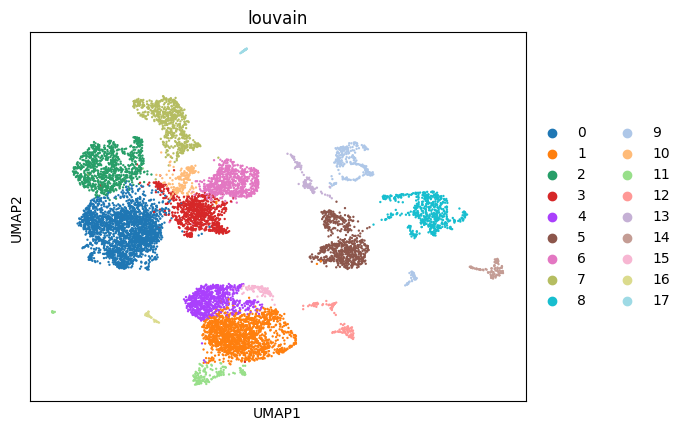

In [18]:
sc.pp.neighbors(adata_eval, use_rep='emb')         # Build neighbor graph using the latent embedding.
sc.tl.louvain(adata_eval, resolution=0.5)            # Run Louvain clustering.
sc.tl.umap(adata_eval)                               # Compute UMAP coordinates.
sc.pl.embedding(adata_eval, color='louvain', basis='umap')  # Visualize the UMAP colored by Louvain clusters.


In [19]:
gt = adata_eval.obs['celltype'].tolist()   # True labels.
pred = adata_eval.obs['louvain'].tolist()     # Louvain cluster labels.

from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

ari = adjusted_rand_score(gt, pred)
nmi = normalized_mutual_info_score(gt, pred)

print("Adjusted Rand Index:", ari)
print("Normalized Mutual Information:", nmi)


Adjusted Rand Index: 0.5381261242290866
Normalized Mutual Information: 0.670490101829075


In [20]:
results_dir = "results"
metrics_dir = os.path.join(results_dir, "metrics")
figures_dir = os.path.join(results_dir, "figures")

os.makedirs(metrics_dir, exist_ok=True)
os.makedirs(figures_dir, exist_ok=True)

In [21]:
metrics = {
    "dataset_name": DATASET_NAME,
    "in_channels": in_channels,
    "hidden_channels": hidden_channels,
    "latent_channels": latent_channels,
    "num_layers": num_layers,
    "learning_rate": learning_rate,
    "n_epochs": n_epochs,
    "ARI": ari,  
    "NMI": nmi   
}

In [58]:
import pandas as pd

# Convert the metrics dictionary into a DataFrame and save as CSV.
df_metrics = pd.DataFrame([metrics])
csv_file = os.path.join(metrics_dir, f"{DATASET_NAME}_results.csv")
df_metrics.to_csv(csv_file, index=False)
print(f"Metrics saved to {csv_file}")

# Save the UMAP plot with Louvain clusters as a PNG.
# Re-run the plotting command with show=False to capture the figure.
sc.pl.embedding(adata_eval, color='louvain', basis='umap', show=False)
# Save the current figure.
umap_fig_path = os.path.join(figures_dir, "umap_louvain.png")
plt.savefig(umap_fig_path)
plt.close()
print(f"UMAP figure saved to {umap_fig_path}")

Metrics saved to results\metrics\LUNG-CITE_results.csv
UMAP figure saved to results\figures\umap_louvain.png


Evaluation on modal prediction task as a downstream evaluation, it tests whether the integrated space retains sufficient information to reconstruct the original data. 

In [32]:
import torch

# Assuming 'data' is your dictionary of AnnData objects per modality
target_modality = "RNA"
target_features = torch.tensor(data[target_modality].X, dtype=torch.float)  # Shape: [num_cells, output_dim]

# Ensure the ordering of cells matches between z and target_features!
output_dim = target_features.shape[1]
print(f"Predicting {target_modality} with output dim: {output_dim}")

Predicting RNA with output dim: 3000


In [33]:
from torch.utils.data import TensorDataset, DataLoader

# Create a dataset pairing the latent embeddings with the target modality features.
dataset = TensorDataset(z.cpu(), target_features)
downstream_loader = DataLoader(dataset, batch_size=256, shuffle=True)

In [34]:
from downstream_tasks.downstream import DownstreamLightningModule
from pytorch_lightning import Trainer

# Instantiate the downstream Lightning module.
downstream_model = DownstreamLightningModule(latent_channels=z.shape[1], output_dim=output_dim, learning_rate=1e-3)

# Train the predictor
downstream_trainer = Trainer(max_epochs=50, accelerator="gpu", devices=1)
downstream_trainer.fit(downstream_model, train_dataloaders=downstream_loader, val_dataloaders=downstream_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | predictor | CrossModalPredictor | 902 K  | train
----------------------------------------------------------
902 K     Trainable params
0         Non-trainable params
902 K     Total params
3.609     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 41/41 [00:01<00:00, 38.23it/s, v_num=4, train_loss=0.476, val_loss=0.423]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 41/41 [00:01<00:00, 36.92it/s, v_num=4, train_loss=0.476, val_loss=0.423]


In [35]:
import torch.nn.functional as F
import numpy as np
from scipy.stats import pearsonr

downstream_model.eval()
with torch.no_grad():
    predictions = downstream_model(z.cpu())  # Shape: [num_cells, output_dim]
    mse_loss = F.mse_loss(predictions, target_features)
    rmse = torch.sqrt(mse_loss)
print(f"Downstream Cross-Modal Prediction RMSE: {rmse.item():.4f}")

# Convert predictions and targets to numpy arrays for PCC calculations.
pred_np = predictions.cpu().numpy().flatten()
target_np = target_features.cpu().numpy().flatten()

# Compute Pearson Correlation Coefficient (PCC)
pcc, _ = pearsonr(pred_np, target_np)
print(f"Pearson Correlation Coefficient: {pcc:.4f}")


Downstream Cross-Modal Prediction RMSE: 0.6504
Pearson Correlation Coefficient: 0.4080


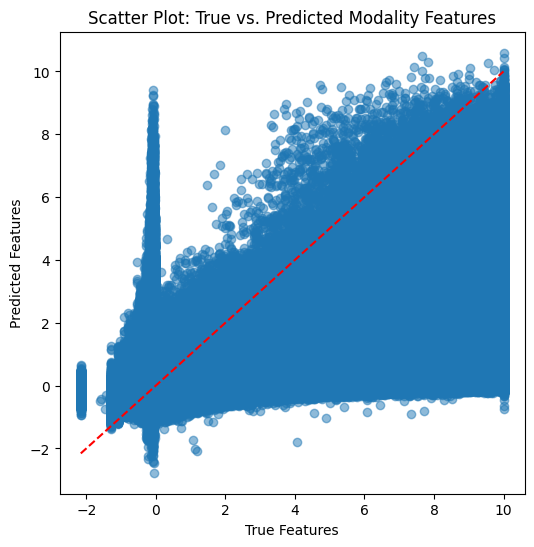

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(target_np, pred_np, alpha=0.5)
plt.plot([target_np.min(), target_np.max()], [target_np.min(), target_np.max()], 'r--')
plt.xlabel("True Features")
plt.ylabel("Predicted Features")
plt.title("Scatter Plot: True vs. Predicted Modality Features")
plt.show()

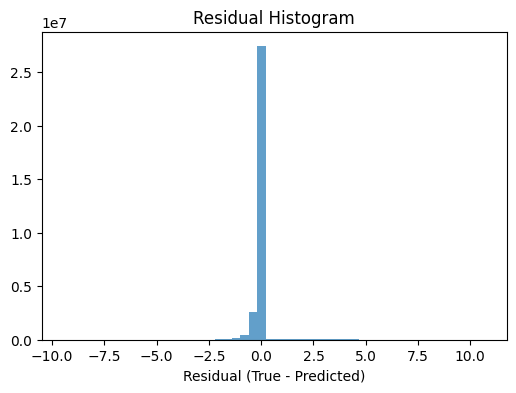

In [37]:
residuals = target_np - pred_np
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=50, alpha=0.7)
plt.xlabel("Residual (True - Predicted)")
plt.title("Residual Histogram")
plt.show()